# Test Task about Thermodynamic State Identification using LLMs



## Loading envirement variables

In [228]:
from dotenv import load_dotenv
import os

# Load environment variables from .env file
load_dotenv()



True

## Loading and exploring the data file

In [ ]:
import pandas as pd

# Load all sheets
excel_file = "Ground Truth Transitions_13 problems_RL.xlsx"
sheets = pd.read_excel(excel_file, sheet_name=None)

# Combine data from all sheets
data = []

for sheet_name, df in sheets.items():
    if 'Problem' in df.columns and 'Condition' in df.columns and 'ChangeOfState' in df.columns:
        for _, row in df.iterrows():
            data.append({
                "problem_id": sheet_name,
                "description": row['Problem'],
                "condition": str(row['Condition']).strip(),
                "state": str(row['ChangeOfState']).strip().lower()
            })

# Create combined DataFrame
df_all = pd.DataFrame(data)




FileNotFoundError: [Errno 2] No such file or directory: 'Gound Truth Transitions_13 problems_RL.xlsx'

In [230]:
print(df_all)


    problem_id                                        description condition  \
0     Problem1  # **Question:** A gas in a cylinder is compres...      True   
1     Problem1                                                NaN      True   
2     Problem1  # The gas is ideal, with R = 287 J/(kg K) and ...      True   
3     Problem1                                                NaN     False   
4     Problem1                #**Answer:** $p = 118778.571428571$     False   
..         ...                                                ...       ...   
124  Problem13                                                NaN     False   
125  Problem13                                                NaN      True   
126  Problem13                                                NaN     False   
127  Problem13                                                NaN     False   
128  Problem13                                                NaN      True   

              state  
0       equilibrium  
1      


## Cleaning dataset to remove unnessary information

In [231]:
import re

# Function to clean a single problem description
def clean_problem_text(text):
    if not isinstance(text, str):
        return ""
    
    # Remove anything after "# **Answer:**" or "#**Answer:**"
    text = re.split(r'#\s*\*\*Answer:\*\*', text)[0]
    
    # Optionally: Remove trailing spaces and redundant newlines
    text = text.strip()
    text = re.sub(r'\n+', '\n', text)
    
    return text

# Apply cleaning function to the 'description' column
df_all['description'] = df_all['description'].apply(clean_problem_text)


In [232]:
df_all[:7]

,problem_id,description,condition,state
0,Problem1,# **Question:** A gas in a cylinder is compres...,True,equilibrium
1,Problem1,,True,adiabatic
2,Problem1,"# The gas is ideal, with R = 287 J/(kg K) and ...",True,reversible
3,Problem1,,False,is_isothermal
4,Problem1,,False,is_isochoric
5,Problem1,,True,is_polytropic
6,Problem1,,False,is_isobaric


## Classifications using LLM

In [233]:

USE_OLLAMA_API = True # Set to True if you want to use the Ollama API
USE_GROQ_API = False # Set to True if you want to use the Groq API

# Model name for Ollama API
ollama_model_name = "llama3.2:latest" # "qwen2.5:3b", "phi3:3.8b", "llama3.1:8b", "llama3.2:latest", "gemma3:12b" ... 

# Model name for Groq API
groq_model_name = "llama-3.3-70b-versatile" #"llama-3.3-70b-versatile",

import time
import json
import pandas as pd
from ollama import chat
from ollama import ChatResponse
import os
from groq import Groq

# Direct Instruction Prompt Template
prompt_template_1 = """
You are tasked with identifying the thermodynamic changes of state occurring in the following problem description.
ONLY choose from the following list of all possible changes:
- equilibrium
- adiabatic
- reversible
- is_isothermal
- is_isochoric
- is_polytropic
- is_isobaric
- is_isenthalpic
- is_isentropic
Problem Description: 
"""

# Checklist-Style Command Prompt Template
prompt_template_2 = """
Analyze the problem description carefully. Identify and list any thermodynamic state changes that apply. Select only from this set:

    equilibrium

    adiabatic

    reversible

    is_isothermal

    is_isochoric

    is_polytropic

    is_isobaric

    is_isenthalpic

    is_isentropic
    
    Respond with a list of applicable states.

Problem Description:
"""


# Example-Based (Few-Shot) Prompt Template
prompt_template_3 = """
    Example:
    "A gas expands without heat exchange, maintaining entropy." → [adiabatic, reversible]

    Now, based on the following description, list the thermodynamic state changes. Select only from:

        equilibrium

        adiabatic

        reversible

        is_isothermal

        is_isochoric

        is_polytropic

        is_isobaric

        is_isenthalpic

        is_isentropic

Problem Description:
"""

#  Role-based Instruction Prompt Template
prompt_template_4 = """
You are a thermodynamics expert. Given the problem description, identify the thermodynamic state changes that apply. Select only from this set:
- equilibrium
- adiabatic
- reversible
- is_isothermal
- is_isochoric
- is_polytropic
- is_isobaric
- is_isenthalpic
- is_isentropic
Problem Description:
"""

#------------------------------------------------------------
# Initialize prompt template
prompt_template = prompt_template_4 #Options: prompt_template_1, prompt_template_2, prompt_template_3, prompt_template_4
#------------------------------------------------------------

# Initialize list to store responses
responses = []

# First group by 'problem_id'
grouped = df_all.groupby('problem_id')

# Loop through each group
for problem_id, group in grouped:
    # Concatenate all descriptions for this problem_id
    all_descriptions = group['description'].dropna().tolist()
    combined_description = "\n".join(all_descriptions)

    # Build full prompt
    full_prompt = prompt_template + combined_description

    full_prompt += """\nRespond STRICTLY ONLY with a Python list of applicable changes.
                Example format: ["adiabatic", "reversible", "is_isochoric", "is_isenthalpic"].
                Do NOT add any extra information, explanation, intro, or text. You should only respond with the Python list including all possible changes.
                """

    try:
        llm_output = None

        if USE_OLLAMA_API:
            #=======================================================================
            # This is the Ollama API call.
            response: ChatResponse = chat(model=ollama_model_name, messages=[
                {
                    'role': 'user',
                    'content': full_prompt,
                    'temperature': 0.0,
                },
            ])
            print(response['message']['content'])

            llm_output = response.message.content

            #=======================================================================

        elif USE_GROQ_API:
            #=======================================================================
            # This is the Groq API call. We can use it instead of the Ollama API to test
            # various LLM models.
            # Make sure to set the environment variable GROQ_API_KEY with your API key
            # if you want to use this.


            

            client = Groq(
                api_key=os.environ.get("GROQ_API_KEY"),
            )

            chat_completion = client.chat.completions.create(
                messages=[
                    {
                        'role': 'user',
                        'content': full_prompt,
                    }
                ],
                model=groq_model_name,  
            )

            print(chat_completion.choices[0].message.content)

            llm_output = chat_completion.choices[0].message.content
        
        else:
            print("Neither Ollama nor Groq API is enabled. Please set USE_OLLAMA_API or USE_GROQ_API to True.")
            raise ValueError("Neither Ollama nor Groq API is enabled. Please set USE_OLLAMA_API or USE_GROQ_API to True.")
        #=======================================================================

        # Extracting list of states from the LLM output
        # Find the first and last brackets in the output
        # This is a bit of a hack, but it works for the expected output format
        # We assume the output is a well-formed JSON list
        # If the output is not well-formed, we will catch the JSONDecodeError
        # and print a warning message
        # and append an empty list to the responses


        first_bracket = llm_output.find('[')
        last_bracket = llm_output.rfind(']')
        
        predicted_states = []
        if first_bracket != -1 and last_bracket != -1:
            list_text = llm_output[first_bracket:last_bracket+1]
            cleaned_list_text = list_text.replace("'", '"').strip()
            try:
                predicted_states = json.loads(cleaned_list_text)
                print(f"Predicted states: {predicted_states}")
            except json.JSONDecodeError:
                print(f"Warning! Could not parse JSON for problem {problem_id}. Raw text: {list_text}")

        # Now for each row in this group, record the same prediction
        # because problem description is the same for all rows of a particular problem_id
        for _, row in group.iterrows():
            responses.append({
                "problem_id": problem_id,
                "description": row['description'],
                "condition": row['condition'],
                "original_state": row['state'],
                "llm_prediction": predicted_states
            })
        print(f"Done with problem {problem_id}")

    except Exception as e:
        print(f"Error! processing problem {problem_id}: {e}")
        # If there is an error, append empty prediction for all rows in the group
        for _, row in group.iterrows():
            responses.append({
                "problem_id": problem_id,
                "description": row['description'],
                "condition": row['condition'],
                "original_state": row['state'],
                "llm_prediction": []
            })

    time.sleep(0.1)  # optional sleep to reduce load on the API

# Save results
df_llm_predictions = pd.DataFrame(responses)


['adiabatic', 'reversible', 'isobaric', 'isentropic']
Predicted states: ['adiabatic', 'reversible', 'isobaric', 'isentropic']
Done with problem Problem1
["is_isobaric", "is_isothermal", "is_isentropic", "adiabatic", "reversible", "is_polytropic"]
Predicted states: ['is_isobaric', 'is_isothermal', 'is_isentropic', 'adiabatic', 'reversible', 'is_polytropic']
Done with problem Problem10
['isobaric', 'isothermal', 'is_entropic']
Predicted states: ['isobaric', 'isothermal', 'is_entropic']
Done with problem Problem11
['adiabatic', 'isobaric', 'is_isentropic']
Predicted states: ['adiabatic', 'isobaric', 'is_isentropic']
Done with problem Problem12
["adiabatic", "polytropic", "reversible", "isobaric", "is_isentropic"]
Predicted states: ['adiabatic', 'polytropic', 'reversible', 'isobaric', 'is_isentropic']
Done with problem Problem13
["is_isobaric", "is_isothermal", "polytropic"]
Predicted states: ['is_isobaric', 'is_isothermal', 'polytropic']
Done with problem Problem2
["is_isothermal", "isoba

In [234]:
df_llm_predictions[:10]

,problem_id,description,condition,original_state,llm_prediction
0,Problem1,# **Question:** A gas in a cylinder is compres...,True,equilibrium,"[adiabatic, reversible, isobaric, isentropic]"
1,Problem1,,True,adiabatic,"[adiabatic, reversible, isobaric, isentropic]"
2,Problem1,"# The gas is ideal, with R = 287 J/(kg K) and ...",True,reversible,"[adiabatic, reversible, isobaric, isentropic]"
3,Problem1,,False,is_isothermal,"[adiabatic, reversible, isobaric, isentropic]"
4,Problem1,,False,is_isochoric,"[adiabatic, reversible, isobaric, isentropic]"
5,Problem1,,True,is_polytropic,"[adiabatic, reversible, isobaric, isentropic]"
6,Problem1,,False,is_isobaric,"[adiabatic, reversible, isobaric, isentropic]"
7,Problem1,,False,is_isenthalpic,"[adiabatic, reversible, isobaric, isentropic]"
8,Problem1,,True,is_isentropic,"[adiabatic, reversible, isobaric, isentropic]"
9,Problem1,,nan,nan,"[adiabatic, reversible, isobaric, isentropic]"


## Matching LLM results to ground truth values

In [235]:
def check_match(row):
    if pd.isna(row['original_state']):
        return False  # If no original_state, consider it incorrect
   
    if pd.isna(row['condition']):
        return False  # If no condition value, consider it incorrect
    
    return row['original_state'] in row['llm_prediction'] and row['condition'] == "True"

# Creating 'is_correct' column in the DataFrame
df_llm_predictions['is_correct'] = df_llm_predictions.apply(check_match, axis=1)

# Calculating Per-problem_id accuracy of each problem sepratly.
problem_accuracy = df_llm_predictions.groupby('problem_id')['is_correct'].mean()

# Showing per-problem_id accuracy
print("--> Accuracy per Problem ID:")
print(problem_accuracy.apply(lambda x: f"{x:.2%}"))

# Overall accuracy as average of per-problem accuracies
overall_accuracy = problem_accuracy.mean()
print(f"\n--> Overall Accuracy (average of per-problem accuracies): {overall_accuracy:.2%}")

#Save final DataFrame in CSV format
df_llm_predictions.to_csv('llm_results.csv', index=False)
print("Results saved to 'llm_results.csv'.")




--> Accuracy per Problem ID:
problem_id
Problem1      9.52%
Problem10    11.11%
Problem11     0.00%
Problem12    11.11%
Problem13    33.33%
Problem2      0.00%
Problem3     11.11%
Problem4      0.00%
Problem5     22.22%
Problem6      0.00%
Problem7     22.22%
Problem8     22.22%
Problem9     22.22%
Name: is_correct, dtype: object

--> Overall Accuracy (average of per-problem accuracies): 12.70%
Results saved to 'llm_results.csv'.


In [236]:
# Create a DataFrame for better display
accuracy_df = problem_accuracy.reset_index()
accuracy_df['accuracy_percent'] = (accuracy_df['is_correct'] * 100).round(2).astype(str) + '%'


# Display nicely
from IPython.display import display, Markdown

display(Markdown("### 📊 Accuracy per Problem:"))
display(accuracy_df[['problem_id', 'accuracy_percent']])

# Overall Accuracy
overall_accuracy = problem_accuracy.mean()

display(Markdown(f"### 🏆 Overall Accuracy (Average across Problems): **{overall_accuracy:.2%}**"))

# Save final DataFrame
df_llm_predictions.to_csv('llm_results.csv', index=False)
print("✅ Results saved to 'llm_results.csv'.")




### 📊 Accuracy per Problem:

,problem_id,accuracy_percent
0,Problem1,9.52%
1,Problem10,11.11%
2,Problem11,0.0%
3,Problem12,11.11%
4,Problem13,33.33%
5,Problem2,0.0%
6,Problem3,11.11%
7,Problem4,0.0%
8,Problem5,22.22%
9,Problem6,0.0%


### 🏆 Overall Accuracy (Average across Problems): **12.70%**

✅ Results saved to 'llm_results.csv'.


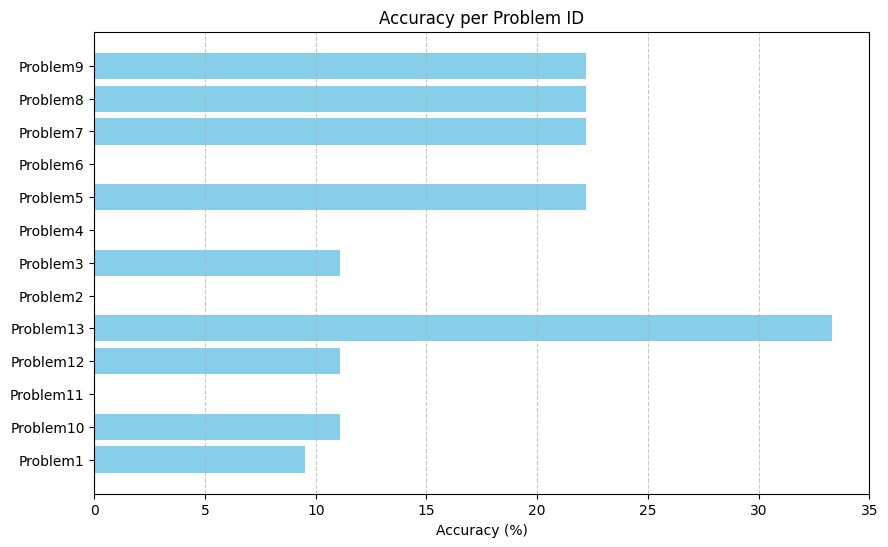

In [237]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.barh(accuracy_df['problem_id'], problem_accuracy * 100, color='skyblue')
plt.xlabel('Accuracy (%)')
plt.title('Accuracy per Problem ID')
plt.grid(True, axis='x', linestyle='--', alpha=0.7)
plt.show()



In [238]:
df_llm_predictions

,problem_id,description,condition,original_state,llm_prediction,is_correct
0,Problem1,# **Question:** A gas in a cylinder is compres...,True,equilibrium,"[adiabatic, reversible, isobaric, isentropic]",False
1,Problem1,,True,adiabatic,"[adiabatic, reversible, isobaric, isentropic]",True
2,Problem1,"# The gas is ideal, with R = 287 J/(kg K) and ...",True,reversible,"[adiabatic, reversible, isobaric, isentropic]",True
3,Problem1,,False,is_isothermal,"[adiabatic, reversible, isobaric, isentropic]",False
4,Problem1,,False,is_isochoric,"[adiabatic, reversible, isobaric, isentropic]",False
...,...,...,...,...,...,...
124,Problem9,,False,is_isochoric,"[adiabatic, reversible, isobaric, is_isotherma...",False
125,Problem9,,True,is_polytropic,"[adiabatic, reversible, isobaric, is_isotherma...",False
126,Problem9,,False,is_isobaric,"[adiabatic, reversible, isobaric, is_isotherma...",False
127,Problem9,,False,is_isenthalpic,"[adiabatic, reversible, isobaric, is_isotherma...",False
